## Creating Visualizations, Correlation Matrices, a Brute-Force Best Subsets Regression, and Predictions using Python

Kenneth Burchfiel

First uploaded to GitHub on 2021-4-24

MIT license

In this program, I will demonstrate how Python can be used to create scatter plot visualizations for different independent variables using a for loop. I will also create a correlation matrix; perform a brute-force best subsets regression; and apply the outcome of that regression to perform predictions for a selection of a dataset.

The dataset I am using is entirely fictional and in the public domain. I generated the data using a Python program that I also uploaded to GitHub (https://github.com/kburchfiel/dataset_generator).

The dataset shows happiness scores for 1600 respondents to a survey, along with various independent variables (income, marital status, etc.) that may predict happiness. This program demonstrates how Python can be used to easily perform visualizations,  regressions, and predictions that might take significantly more time in Excel.

I am still a newcomer to Python, so the code below likely does not represent the most efficient or even most accurate method of performing analyses and visualizations. However, I hope this project may still help others learn how to incorporate Python into data analytics projects.

## Part 1: Setup

First, I will import a series of libraries.

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time
import itertools
import scipy.stats as stats
import numpy as np

Next, I will import the CSV file (which had been produced within another Python program) and copy its data into two separate DataFrames. This will allow me to test a regression model trained on df_happiness on the data stored in df_happiness_test.

In [2]:
df_csv = pd.read_csv('happiness_data.csv',index_col='id')
df_happiness = df_csv[0:1200].copy() # IDs 1-1200. df_csv[0] refers to ID 1, since the IDs start at 1 instead of 0.
df_happiness_test = df_csv[1200:1600].copy() # IDs 1201-1600. Because the last number in a range is not included, df_happiness and df_happiness_test do not overlap, even though the number 1200 appears in both of their slices.


In [3]:
df_happiness

,0_female,1_age,2_num_chronic,3_married,4_urban,5_hours_tv,6_hours_sm,7_num_sunny,8_avg_temp,9_close_friends,10_worship_days,11_years_edu,12_employed_ft,13_income,14_happiness
id,,,,,,,,,,,,,,,
1,1,50,1,1,1,7.2,7.9,136,55.6,8,78,12,1,60607,44
2,1,68,4,0,0,7.0,5.5,104,54.9,7,22,16,0,27155,26
3,1,60,5,0,1,11.4,7.0,132,60.0,8,55,20,1,56371,31
4,0,24,3,0,0,13.1,5.7,139,56.7,5,0,10,1,53930,26
5,1,30,1,1,0,6.1,1.7,108,64.2,0,73,10,1,53575,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,1,50,3,1,1,10.4,3.9,71,66.1,9,119,16,1,57497,41
1197,1,75,4,0,0,7.6,4.6,124,59.0,6,60,18,1,52038,34
1198,0,57,0,1,0,11.0,6.9,124,64.7,0,36,18,1,63872,40


It will be useful to store the independent variables from the DataFrame into a list. These variables are stored in df_happiness_columns:

In [4]:
df_happiness.columns

Index(['0_female', '1_age', '2_num_chronic', '3_married', '4_urban',
       '5_hours_tv', '6_hours_sm', '7_num_sunny', '8_avg_temp',
       '9_close_friends', '10_worship_days', '11_years_edu', '12_employed_ft',
       '13_income', '14_happiness'],
      dtype='object')

Using a for loop, I can next add each independent variable from df_happiness.columns into a list.

In [5]:
iv_list = []
for i in range(len(df_happiness.columns)-1): # The final element in the list is the dependent variable and is therefore excluded from this independent variables list.
    iv_list.append(df_happiness.columns[i])

iv_list

['0_female',
 '1_age',
 '2_num_chronic',
 '3_married',
 '4_urban',
 '5_hours_tv',
 '6_hours_sm',
 '7_num_sunny',
 '8_avg_temp',
 '9_close_friends',
 '10_worship_days',
 '11_years_edu',
 '12_employed_ft',
 '13_income']

## Part 2: Creating scatter plot visualizations using a formula and a for loop

One of the benefits of creating visualizations in Python is that, once the code for a particular visualization is in place, it is easy to iterate through a list of variables and then perform that same visualization for other variables.

The formula below takes series of data for a particular independent and dependent variable; produces a scatter plot showing their relationship; generates and plots a best fit line; and displays various statistics within the plot.

In [6]:
def scatter_and_best_fit(iv_column,dv_column):
    xset = iv_column
    yset = dv_column
    plt.scatter(xset,yset)
    # Creating regression data:
    xreg = xset
    xreg = sm.add_constant(xreg)
    yreg = yset
    output = sm.OLS(yreg,xreg)
    results = output.fit()
    regression_dict = {}
    rsquared = results.rsquared
    # results.params() returns a tuple containing the coefficient (beta) and the intercept (alpha), so the following two lines of code access those elements of the tuple for the purposes of creating a best fit line
    beta = results.params[1] # coefficient
    alpha = results.params[0] # intercept
    adj_rsquared = results.rsquared_adj
    width = iv_column.max()-iv_column.min()
    left = iv_column.min() + width/30 # Used to position chart labels
    top = dv_column.max() # Used to position chart labels 
    height = dv_column.max()-dv_column.min()
    height_inc = height/15 # This creates an offset that can be used to appropriately space chart labels so that they don't overlap. It is meant to be useful for many different axis heights.
    # Creating coordinates of best fit line:
    xfit = np.linspace(iv_column.min(), iv_column.max(), 2) # x range for the best fit line. The range is based on the minimum and maximum independent variable values. Only two points are needed since the best fit line is linear.
    yfit = alpha + beta * xfit
    #The above line of code multiplies the given x value by the stock's beta and adds the product to the stock's alpha. The resulting xfit and yfit coordinates form the regression's best fit line.
    plt.plot(xfit, yfit)
    background = (1, 1, 1, 0.5) # This variable will be used to set the background color of the text below to white with an alpha of 0.5 (making it translucent). See https://matplotlib.org/stable/tutorials/colors/colors.html and https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html#matplotlib.pyplot.text 
    plt.text(left, top-height_inc, "Coeff: "+str(round(beta,3)),backgroundcolor=background)
    plt.text(left, top-height_inc*2, "Intercept: "+str(round(alpha,3)),backgroundcolor=background)
    plt.text(left, top-height_inc*3, "R^2: "+str(round(rsquared,3)),backgroundcolor=background)
    plt.text(left, top-height_inc*4, "Adj. R^2: "+str(round(adj_rsquared,3)),backgroundcolor=background)
    plt.text(left, top-height_inc*5, "Coefficient P value: "+str(round(results.pvalues[1],4)),backgroundcolor=background)
    plt.xlabel(iv_column.name) # I believe .name works in this case because iv_column and dV_column are each columns in the DataFrame.
    plt.ylabel(dv_column.name)
    plt.title("Relationship between "+ iv_column.name+" and "+dv_column.name)
    plt.show()


Now that the formula has been created, I can use it to produce a scatter plot showing the relationship between each independent variable and the dependent variable (happiness). The graphs are not the most aesthetically pleasing, and some of the data are covered by the regression statistics, but they provide an overview of how different variables are correlated with the happiness data.


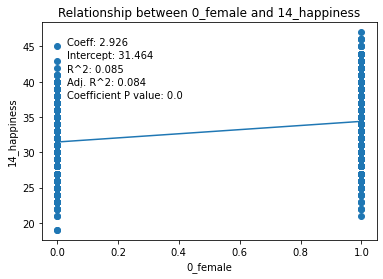

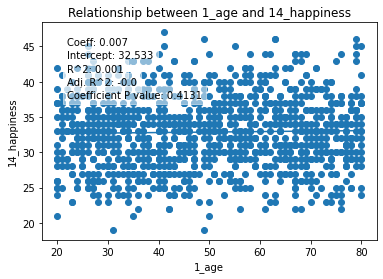

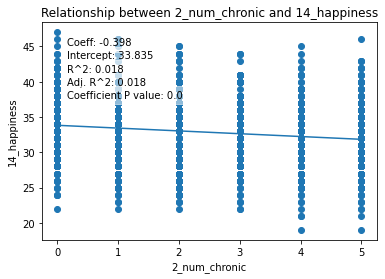

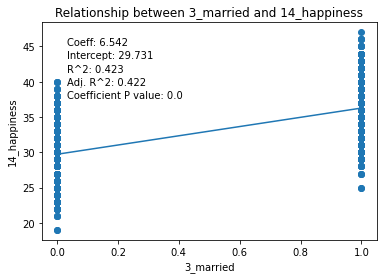

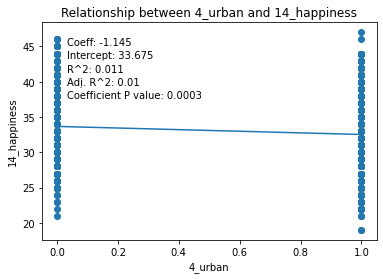

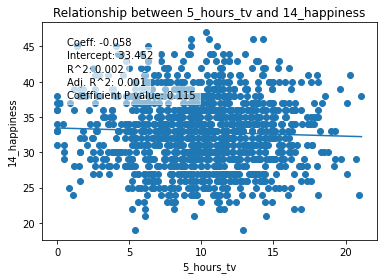

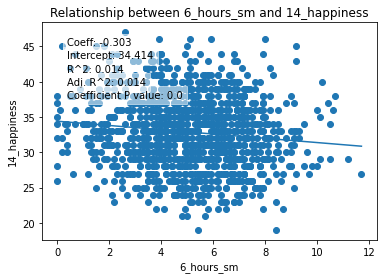

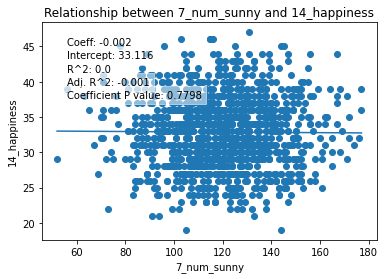

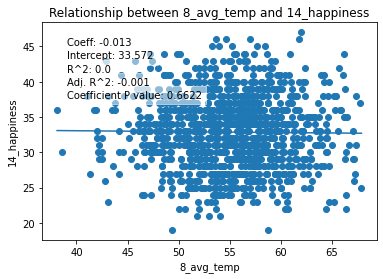

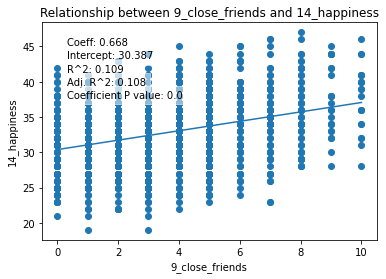

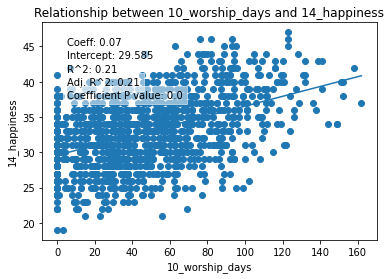

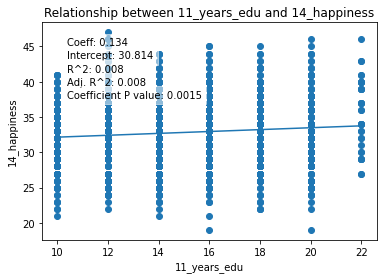

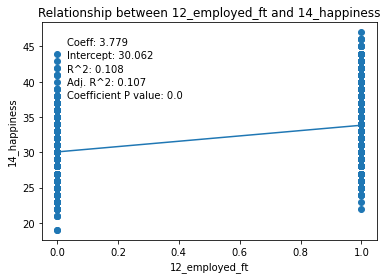

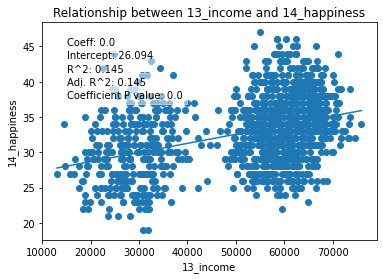

In [7]:
for iv in iv_list:
    scatter_and_best_fit(df_happiness[iv],df_happiness['14_happiness'])

## Part 3: Developing a correlation matrix

I will now create a correlation matrix in order to identify strong relationships between certain variables. This will help me determine which variables, if any, I can remove from my independent variables list without causing much reduction in the regression models' explanatory power.

In [8]:
# Creating the structure of the matrix:
df_corr_matrix = pd.DataFrame(index=iv_list,columns=iv_list)
df_corr_matrix

,0_female,1_age,2_num_chronic,3_married,4_urban,5_hours_tv,6_hours_sm,7_num_sunny,8_avg_temp,9_close_friends,10_worship_days,11_years_edu,12_employed_ft,13_income
0_female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1_age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2_num_chronic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3_married,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4_urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5_hours_tv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6_hours_sm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7_num_sunny,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8_avg_temp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9_close_friends,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Filling the matrix with correlations. The code below can be summarized as follows: 
# "For each column and row of the DataFrame, calculate the correlation between the IV (independent variable) shown in the column and the IV shown in the row, then store that correlation in the cell where those rows and columns overlap."
df_corr_matrix.iloc[0,0]
for i in range(len(df_corr_matrix.columns)):
    for j in range(len(df_corr_matrix.index)):
        df_corr_matrix.iloc[j,i] = np.corrcoef(df_happiness[df_corr_matrix.columns[i]],df_happiness[df_corr_matrix.columns[j]])[0][1] #NumPy's corrcoef function produces a 2x2 output, so the [0][1] at the end of the function selects just the r value from that output. 
df_corr_matrix

,0_female,1_age,2_num_chronic,3_married,4_urban,5_hours_tv,6_hours_sm,7_num_sunny,8_avg_temp,9_close_friends,10_worship_days,11_years_edu,12_employed_ft,13_income
0_female,1.0,0.066019,0.007988,-0.016559,0.006047,0.049844,-0.041771,-0.037528,-0.004746,0.554715,0.450675,0.101627,-0.037816,-0.195162
1_age,0.066019,1.0,0.026141,-0.038348,0.031517,-0.054318,-0.010271,0.002902,0.050934,0.042292,0.033328,-0.015659,0.025801,0.009397
2_num_chronic,0.007988,0.026141,1.0,-0.00035,0.006196,0.033192,-0.049861,0.032072,0.007365,0.002144,0.046796,-0.009264,-0.040997,-0.054176
3_married,-0.016559,-0.038348,-0.00035,1.0,-0.009632,-0.010124,-0.047214,0.013167,-0.008905,-0.007204,0.019581,0.018956,0.022301,0.21024
4_urban,0.006047,0.031517,0.006196,-0.009632,1.0,0.011326,0.01898,0.009429,0.018352,0.011045,-0.005401,-0.029306,0.02241,0.119008
5_hours_tv,0.049844,-0.054318,0.033192,-0.010124,0.011326,1.0,0.036733,-0.008012,-0.004566,0.024048,-0.008807,0.000254,0.075713,0.018777
6_hours_sm,-0.041771,-0.010271,-0.049861,-0.047214,0.01898,0.036733,1.0,0.008893,-0.061539,-0.009153,-0.049425,-0.028895,-0.028662,-0.05875
7_num_sunny,-0.037528,0.002902,0.032072,0.013167,0.009429,-0.008012,0.008893,1.0,0.045883,-0.033196,0.007797,-0.052693,-0.010055,-0.008556
8_avg_temp,-0.004746,0.050934,0.007365,-0.008905,0.018352,-0.004566,-0.061539,0.045883,1.0,-0.008132,0.000605,-0.023132,0.000108,-0.001642
9_close_friends,0.554715,0.042292,0.002144,-0.007204,0.011045,0.024048,-0.009153,-0.033196,-0.008132,1.0,0.219928,0.101009,-0.010945,-0.086563


In reviewing the matrix, I see that some variables appear to have significant correlations with one another (female and # of close friends, for instance.) In fact, the correlation between full-time employment and income is very strong (0.926), indicating that I could safely remove full-time employment from my model without sacrificing much, if any explanatory power. 

However, in order to show what a full brute-force best subsets regression on this data looks like, I will leave this variable in.

## Part 4: Performing a brute-force best subsets regression

Given *n* independent variables, the number of unique combinations of those variables equals 2^n-1, since each variable can either be included or not included. (1 is subtracted from 2^n to remove the empty subset from the total.)

In this example, there are 2^14-1 = 16,383 possible subsets of the 14 independent variables in the dataset. Using a brute-force approach, it is possible to determine which of these subsets produces the highest adjusted R^2 when entered into a regression formula. Although a stepwise regression or the lasso method (as pointed out by Professor David Guetta) might make more sense in a real-world application, it's still interesting to see how Python can make a brute-force approach possible. 

First, I will create a function that, given a list of variables, produces a list of all possible subsets of that variable list.

In [10]:
def create_subset_list(iv_list):
    # This formula creates a list of all possible independent variable subsets that can be created from iv_list. Each subset is stored in list form. The method shown in the formula was suggested by my Python professor at CBS (Mattan Griffel).
    subset_list = []
    for i in range(len(iv_list)+1): # I needed to add the +1 to len(iv_list) in order for the formula to include the subset containing all variables--probably because range loops don't contain the last element in the range.
        combinations_list = itertools.combinations(iv_list,i) # Returns an element containing tuples with type "itertools.combinations." It's possible to iterate through this element and retrieve each tuple within it, which I'll do below.
        # itertools.combinations() documentation: https://docs.python.org/3/library/stdtypes.html#list
        # print(type(combinations_list))
        for element in combinations_list:
            # print(element,type(element)) # Shows that each element created by combinations_list is a tuple
            if len(element) > 0:
                subset_list.append(list(element)) # https://docs.python.org/3/library/stdtypes.html#list # Converts each tuple in combinations_list other than the empty tuple (i.e. the tuple with len(0)) into a list, then appends that list to subset_list. This will make it easier for the regression function below to use each element of the combinations list as a set of independent variables.
    return(subset_list)



Next, I will apply this formula to the independent variable list created earlier.

In [11]:
subset_list = create_subset_list(iv_list)
print(len(subset_list)) # shows how many independent variable subsets our list contains

max_len = 0
for item in subset_list:
    if len(item) > max_len:
        max_len = len(item)
print(max_len) # Verifies that the subset with all variables was included in subset_list


16383
14


A selection of the subset list: (Note that each element of the list is itself a list)

In [12]:
for i in range(0,17000,1000):
    print(subset_list[i])

['0_female']
['2_num_chronic', '3_married', '7_num_sunny', '9_close_friends']
['0_female', '4_urban', '5_hours_tv', '11_years_edu', '12_employed_ft']
['2_num_chronic', '8_avg_temp', '9_close_friends', '12_employed_ft', '13_income']
['0_female', '2_num_chronic', '3_married', '4_urban', '11_years_edu', '12_employed_ft']
['1_age', '2_num_chronic', '5_hours_tv', '8_avg_temp', '9_close_friends', '11_years_edu']
['2_num_chronic', '7_num_sunny', '8_avg_temp', '10_worship_days', '12_employed_ft', '13_income']
['0_female', '1_age', '3_married', '8_avg_temp', '9_close_friends', '10_worship_days', '11_years_edu']
['0_female', '4_urban', '5_hours_tv', '6_hours_sm', '8_avg_temp', '10_worship_days', '11_years_edu']
['1_age', '4_urban', '6_hours_sm', '8_avg_temp', '9_close_friends', '12_employed_ft', '13_income']
['0_female', '1_age', '2_num_chronic', '3_married', '5_hours_tv', '6_hours_sm', '8_avg_temp', '12_employed_ft']
['0_female', '2_num_chronic', '3_married', '5_hours_tv', '7_num_sunny', '8_avg

Next, I will perform a regression on each subset; append various statistics from that regression to a dictionary; and append each dictionary to a list of dictionaries. 

It can take a while to evaluate thousands of regressions, so this function also provides periodic updates on its progress and estimates of how much longer it will take to finish.

In [13]:
def subset_regressions(subset_list, dv, df):
        start_time = time.time() # https://docs.python.org/3/library/time.html#time.time
        previous_time = time.time()
        regression_dict_list = []
        batch_count = 2000 # Determines how often an update on the function's progress appears
        for i in range(len(subset_list)):
                y = dv
                x = df[subset_list[i]] # This method of adding a list of IVs is based on a Stack Overflow answer by unutbu: https://stackoverflow.com/a/29186780/13097194 .
                x = sm.add_constant(x)
                output = sm.OLS(y,x)
                results = output.fit()
                regression_dict = {}
                regression_dict['IVs']=subset_list[i] # Stores the list of independent variables used in the regression into the dictionary
                regression_dict['IV_count']=len(subset_list[i])
                regression_dict['rsquared']=results.rsquared
                regression_dict['adj_rsquared']=results.rsquared_adj
                # regression_dict['summary']=results.summary() It is possible to store each regression summary into the output, but an easier method is to generate the summary output as needed for a given independent variable list. This method will be shown below.
                regression_dict_list.append(regression_dict)
                # The following code calculates various statistics about the length of the program's duration and its rate of progress, then outputs those statistics to a print() statement.
                if (i+1) % batch_count == 0: # At this stage in the code, i is one less than the number of regressions created so far; thus, 1 is added to i to compensate for this difference. Note that, without the parentheses, the expression on the left will be interpreted as i + (1 % batch_count).
                        regressions_created = i+1
                        current_time = time.time()
                        time_elapsed = current_time - start_time
                        time_since_last_set = current_time - previous_time
                        proportion_complete = regressions_created/len(subset_list) 
                        regressions_per_second = regressions_created/time_elapsed
                        regressions_per_second_last_set = batch_count/time_since_last_set
                        regressions_left = len(subset_list)-regressions_created
                        estimated_seconds_left = regressions_left/regressions_per_second
                        estimated_seconds_left_based_on_last_set = regressions_left/regressions_per_second_last_set
                        print("Total regressions appended to list:",regressions_created,
                        "\nPercent complete:",'{:.2%}'.format(proportion_complete),
                        "\nSeconds elapsed:",'{:.2f}'.format(time_elapsed),
                        "\nRegressions per second (cumulative):",'{:.2f}'.format(regressions_per_second),
                        "\nTime last",batch_count,"regressions took:",'{:.2f}'.format(time_since_last_set),
                        "\nRegressions per second for last",batch_count,"regressions:",'{:.2f}'.format(regressions_per_second_last_set),
                        "\nRegressions left:",regressions_left,
                        "\nEstimated seconds left:",'{:.2f}'.format(estimated_seconds_left),
                        "\nEstimated seconds left based on time needed for last",batch_count,"regressions:",'{:.2f}'.format(estimated_seconds_left_based_on_last_set),
                        '\n\n\n\n\n')
                        previous_time = current_time # Stores current_time as previous time so that the next set of time calculations can reference it
                if i+1 == len(subset_list):
                        regressions_created = i+1
                        current_time = time.time()
                        time_elapsed = current_time - start_time
                        regressions_per_second = regressions_created/time_elapsed
                        print("Regression list complete.",
                        "\nTotal regressions appended to list:",regressions_created,
                        "\nSeconds elapsed:",'{:.2f}'.format(time_elapsed),
                        "\nRegressions per second (cumulative):",'{:.2f}'.format(regressions_per_second))
        return regression_dict_list

In [14]:
# Useful for testing updates to the above formula on just a small section of subset_list: 
# subset_regressions(subset_list[0:100],df_happiness['14_happiness'],df_happiness)

Having defined my subset_regressions function, I can now feed my list of independent variable subsets into it, then convert the output of the function into a DataFrame. This will allow me to determine which subset has the highest adjusted R^2.

In [15]:
regression_table = subset_regressions(subset_list,df_happiness['14_happiness'],df_happiness)
df_regressions = pd.DataFrame(regression_table)

Total regressions appended to list: 2000 
Percent complete: 12.21% 
Seconds elapsed: 13.74 
Regressions per second (cumulative): 145.59 
Time last 2000 regressions took: 13.74 
Regressions per second for last 2000 regressions: 145.59 
Regressions left: 14383 
Estimated seconds left: 98.79 
Estimated seconds left based on time needed for last 2000 regressions: 98.79 





Total regressions appended to list: 4000 
Percent complete: 24.42% 
Seconds elapsed: 30.37 
Regressions per second (cumulative): 131.69 
Time last 2000 regressions took: 16.64 
Regressions per second for last 2000 regressions: 120.22 
Regressions left: 12383 
Estimated seconds left: 94.03 
Estimated seconds left based on time needed for last 2000 regressions: 103.00 





Total regressions appended to list: 6000 
Percent complete: 36.62% 
Seconds elapsed: 47.12 
Regressions per second (cumulative): 127.34 
Time last 2000 regressions took: 16.74 
Regressions per second for last 2000 regressions: 119.44 
Regressions left

The output above shows the function's progress. It makes sense that the regressions per second metric decreases over the length of the function, as the subsets in subset_list are ordered from shortest to longest, and I imagine that regressions with more independent variables usually take longer to compute.

In [16]:
df_regressions # The DataFrame conversion of subset_regressions

,IVs,IV_count,rsquared,adj_rsquared
0,[0_female],1,0.084560,0.083796
1,[1_age],1,0.000559,-0.000275
2,[2_num_chronic],1,0.018436,0.017617
3,[3_married],1,0.422604,0.422122
4,[4_urban],1,0.010837,0.010011
...,...,...,...,...
16378,"[0_female, 1_age, 2_num_chronic, 4_urban, 5_ho...",13,0.634970,0.630969
16379,"[0_female, 1_age, 3_married, 4_urban, 5_hours_...",13,0.810464,0.808386
16380,"[0_female, 2_num_chronic, 3_married, 4_urban, ...",13,0.829694,0.827827
16381,"[1_age, 2_num_chronic, 3_married, 4_urban, 5_h...",13,0.830077,0.828215


The following code block sorts the Dataframe so that the regressions with the highest adjusted R^2 will appear on top.

In [17]:
df_regressions.sort_values('adj_rsquared', ascending=False, inplace=True)
df_regressions

,IVs,IV_count,rsquared,adj_rsquared
15659,"[1_age, 2_num_chronic, 3_married, 4_urban, 5_h...",10,0.829954,0.828524
16219,"[1_age, 2_num_chronic, 3_married, 4_urban, 5_h...",11,0.830031,0.828457
16216,"[1_age, 2_num_chronic, 3_married, 4_urban, 5_h...",11,0.830001,0.828427
15945,"[0_female, 1_age, 2_num_chronic, 3_married, 4_...",11,0.829975,0.828400
16211,"[1_age, 2_num_chronic, 3_married, 4_urban, 5_h...",11,0.829958,0.828383
...,...,...,...,...
7,[7_num_sunny],1,0.000065,-0.000769
33,"[1_age, 8_avg_temp]",2,0.000751,-0.000919
32,"[1_age, 7_num_sunny]",2,0.000626,-0.001044
84,"[7_num_sunny, 8_avg_temp]",2,0.000216,-0.001455


Given the length of time needed to produce this DataFrame, it is a good idea to store it in a .csv file so that the data can be accessed again without re-running subset_regressions.

In [18]:
df_regressions.to_csv('df_regressions_output.csv')

Next, I will store the independent variable subset that produced the regression with the highest R^2 into its own list.

In [19]:
max_rsquared_iv_row = df_regressions.loc[df_regressions['adj_rsquared'] == max(df_regressions['adj_rsquared'])] # Retrieves the row of df_regressions whose adj_rsquared is the highest of any rows. I believe multiple rows will be returned if there is a tie for the highest adjusted r^2.
max_rsquared_iv_list = max_rsquared_iv_row.iloc[0,0] # Retrieves the list of independent variables from this row. If multiple rows are stored in max_rsquared_iv_row, only the list from the top row will be stored in max_rsquared_iv_list.
max_rsquared_iv_list

['1_age',
 '2_num_chronic',
 '3_married',
 '4_urban',
 '5_hours_tv',
 '6_hours_sm',
 '9_close_friends',
 '10_worship_days',
 '12_employed_ft',
 '13_income']

Using this list, I will now run a regression on that list in order to display that list's summary statistics.

In [20]:
y = df_happiness['14_happiness']
x = df_happiness[max_rsquared_iv_list] # This method of adding a list of IVs is based on a Stack Overflow answer by unutbu: https://stackoverflow.com/a/29186780/13097194
x = sm.add_constant(x)
output = sm.OLS(y,x)
max_adj_rsquared_results = output.fit()
max_adj_rsquared_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           14_happiness   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     580.3
Date:                Sat, 24 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:16:12   Log-Likelihood:                -2577.6
No. Observations:                1200   AIC:                             5177.
Df Residuals:                    1189   BIC:                             5233.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              24.1576      0.550     43.943      0.000      23.079      25.236
1_age               0.0056      0.003      1.614      0.107      -0.001       0.012
2_num_chronic      -0.4133      0.035    -11.731      0.000      -0.482      -0.344
3_married           6.1632      0.144     42.762      0.000       5.880       6.446
4_urban            -1.2626      0.140     -9.044      0.000      -1.537      -0.989
5_hours_tv         -0.0666      0.016     -4.285      0.000      -0.097      -0.036
6_hours_sm         -0.1468      0.030     -4.821      0.000      -0.206      -0.087
9_close_friends     0.5200      0.025     20.486      0.000       0.470       0.570
10_worship_days     0.0626      0.002     32.791      0.000       0.059       0.066
12_employed_ft      2.6738      0.459      5.824      0.000       1.773       3.574
13_income         3.64e-05   1.41e-05      2.590      0.010    8.83e-06     6.4e-05
==============================================================================
Omnibus:                      627.133   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.275
Skew:                          -0.021   Prob(JB):                     4.06e-15
Kurtosis:                       1.849   Cond. No.                     6.01e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This regression output includes 10 out of the 14 individual variables examined, indicating that the other 4 (gender; number of sunny days; aveage temperature; and years of education) did not add true predictive power to the model. 

The output of the model shows that, on average, higher happiness is positively correlated with (1) being older\*; (2) having fewer chronic conditions; (2) being married; (3) not living in an urban area; (4) spending less time watching TV and browsing social media; (5) attending worship services more often; (6) being employed full-time; and (7) having a higher income. (Again, however, these 'results' are based on **fictional** data.)

\* This variable is not statistically significant, but still appears useful for generating happiness score predictions.

## Part 5: Using the regression model with the highest adjusted R^2 to make predictions, then evaluating the accuracy of those predictions

Now that I know which of the 16,383 models has the highest adjusted R^2, I can use that model to make predictions about the 400 participants in df_happiness_tese, then evaluate how accurate those predictions were.

First, I will store the coefficients from the regression results above in a list:

In [21]:
df_coefficients = pd.DataFrame(max_adj_rsquared_results.params) # These coefficients are taken from the model with the highest adjusted R^2.
df_coefficients.columns=['Coefficients']
df_coefficients

,Coefficients
const,24.157604
1_age,0.005607
2_num_chronic,-0.413271
3_married,6.163165
4_urban,-1.262609
5_hours_tv,-0.066611
6_hours_sm,-0.146759
9_close_friends,0.519994
10_worship_days,0.062556
12_employed_ft,2.673759


These coefficients were 'trained' on participants 1 through 1200 in the survey. To test their accuracy, I will now 'test' the regression model on participants 1201 through 1600, whose survey results are stored in df_happiness_test. 

In [22]:
df_happiness_test

,0_female,1_age,2_num_chronic,3_married,4_urban,5_hours_tv,6_hours_sm,7_num_sunny,8_avg_temp,9_close_friends,10_worship_days,11_years_edu,12_employed_ft,13_income,14_happiness
id,,,,,,,,,,,,,,,
1201,0,36,5,1,1,7.1,4.4,147,54.7,1,25,10,0,31457,28
1202,0,26,5,1,1,8.2,2.0,142,51.3,1,26,14,0,31254,33
1203,0,72,4,0,0,3.4,1.1,127,57.6,4,37,10,1,59662,33
1204,1,52,4,1,1,3.0,1.0,114,54.2,6,56,18,1,61731,36
1205,0,72,2,1,1,8.7,6.5,150,57.0,0,27,20,1,70222,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596,1,20,2,1,1,6.1,9.7,105,51.3,7,55,18,1,67835,37
1597,1,75,3,0,1,8.9,5.2,86,59.9,2,43,18,1,59798,29
1598,1,29,0,0,1,4.5,5.4,137,53.5,6,61,16,1,61423,34


Producing the predictions for each user will involve matrix multiplication. The two series to be multiplied are (1) the coefficients from the best-performing regression and (2) the survey results from each participant in df_happiness_test.

df_happiness_test includes all independent variables, including some that are not part of the best-performing regression model. Fortunately, it is possible to select only the columns containing the best-performing parameters using the following approach:

1. Select the list of variables from the best-performing regression model (generated earlier as max_rsquared_iv_list).

2. Use this list as a parameter in a .loc expression

In [23]:
max_rsquared_iv_list # List of variables from best-performing regression model

['1_age',
 '2_num_chronic',
 '3_married',
 '4_urban',
 '5_hours_tv',
 '6_hours_sm',
 '9_close_friends',
 '10_worship_days',
 '12_employed_ft',
 '13_income']

In [24]:
df_happiness_test.loc[df_happiness_test.index[0],max_rsquared_iv_list] # This line selects data from df_happiness_test that (1) is in row 0 (as specified by .index[0] and (2) exists within one of the columns in max_rsquared_iv_list. See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#combining-positional-and-label-based-indexing


1_age                 36.0
2_num_chronic          5.0
3_married              1.0
4_urban                1.0
5_hours_tv             7.1
6_hours_sm             4.4
9_close_friends        1.0
10_worship_days       25.0
12_employed_ft         0.0
13_income          31457.0
Name: 1201, dtype: float64

In [ ]:
# The independent variable coefficients themselves can be retrieved from df_coefficients as follows:

In [25]:
df_coefficients.iloc[1:,0] # Skipping row 1, which contains the constant/intercept

1_age              0.005607
2_num_chronic     -0.413271
3_married          6.163165
4_urban           -1.262609
5_hours_tv        -0.066611
6_hours_sm        -0.146759
9_close_friends    0.519994
10_worship_days    0.062556
12_employed_ft     2.673759
13_income          0.000036
Name: Coefficients, dtype: float64

Having shown how to retrieve the two series to be multiplied for the purpose of making predictions, I will now generate predictions for each participant in df_happiness_test.

In [28]:
df_happiness_test['prediction']=0 # Creates a column in df_happiness_test in which to store the predictions
for i in range(len(df_happiness_test)):
    prediction = np.matmul(df_happiness_test.loc[df_happiness_test.index[i],max_rsquared_iv_list],df_coefficients.iloc[1:,0])+df_coefficients.iloc[0,0]
    # For a given participant, the above line multiplies each participant's independent variable values by that variable's coefficients (stored in df_coefficients). As discussed earlier, only the variables included in the regression with the highest R^2 factor into this matrix multiplication. The intercept (stored in df_coefficients.iloc[0,0]) is then added to the project to produce the final prediction.
    df_happiness_test.loc[df_happiness_test.index[i],'prediction'] = prediction # Stores the prediction for that respondent in the prediction column

df_happiness_test


,0_female,1_age,2_num_chronic,3_married,4_urban,5_hours_tv,6_hours_sm,7_num_sunny,8_avg_temp,9_close_friends,10_worship_days,11_years_edu,12_employed_ft,13_income,14_happiness,prediction
id,,,,,,,,,,,,,,,,
1201,0,36,5,1,1,7.1,4.4,147,54.7,1,25,10,0,31457,28,29.303869
1202,0,26,5,1,1,8.2,2.0,142,51.3,1,26,14,0,31254,33,29.581912
1203,0,72,4,0,0,3.4,1.1,127,57.6,4,37,10,1,59662,33,31.760241
1204,1,52,4,1,1,3.0,1.0,114,54.2,6,56,18,1,61731,36,38.893830
1205,0,72,2,1,1,8.7,6.5,150,57.0,0,27,20,1,70222,33,34.020632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596,1,20,2,1,1,6.1,9.7,105,51.3,7,55,18,1,67835,37,38.737255
1597,1,75,3,0,1,8.9,5.2,86,59.9,2,43,18,1,59798,29,29.299950
1598,1,29,0,0,1,4.5,5.4,137,53.5,6,61,16,1,61423,34,33.810692


The predictions for each user are now stored in the above DataFrame. In order to evaluate how accurate these predictions are, I will now run a regression with the actual happiness scores as the y variable and the predictions as the x variable.

In [29]:
y = df_happiness_test['14_happiness']
x = df_happiness_test['prediction'] # This method of adding a list of IVs is based on a Stack Overflow answer by unutbu: https://stackoverflow.com/a/29186780/13097194
x = sm.add_constant(x)
output = sm.OLS(y,x)
prediction_results = output.fit()
prediction_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           14_happiness   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     1909.
Date:                Sat, 24 Apr 2021   Prob (F-statistic):          6.16e-154
Time:                        16:16:14   Log-Likelihood:                -864.44
No. Observations:                 400   AIC:                             1733.
Df Residuals:                     398   BIC:                             1741.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5719      0.769     -0.743      0.458      -2.084       0.941
prediction     1.0202      0.023     43.687      0.000       0.974       1.066
==============================================================================
Omnibus:                      171.532   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.203
Skew:                           0.057   Prob(JB):                     1.51e-05
Kurtosis:                       1.851   Cond. No.                         241.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The adjusted R^2 from this regression output is 0.827, indicating that the prediction model created earlier explains about 82.7% of the variation in happiness scores among participants in df_happiness_test (the test set). This is only slightly less than the 82.9% of the variation explained by the model for participants in df_happiness (the training set).

It is expected that the test set's adjusted R^2 would be lower than the training set because the coefficients were 'trained' on that training set.

The relationship between predicted scores and actual scores can be portrayed as a scatter plot:

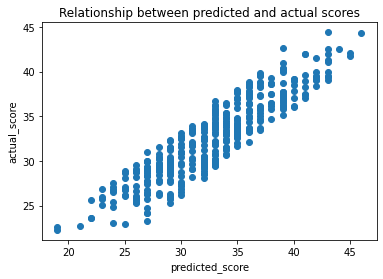

In [31]:
xset = df_happiness_test['14_happiness']
yset = df_happiness_test['prediction']

plt.scatter(xset,yset)
plt.xlabel('predicted_score') 
plt.ylabel('actual_score')
plt.title("Relationship between predicted and actual scores")
plt.show()


Alternately, a scatter plot can be generated with the participant number as the x variable and both predicted and actual happiness scores as the y variables. However, with 400 data points, this graph becomes difficult to interpret.

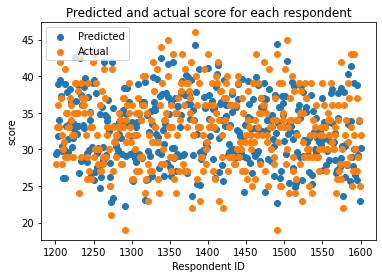

In [41]:
respondent_list = df_happiness_test.index
yset1 = df_happiness_test['prediction']
yset2 = df_happiness_test['14_happiness']
plt.scatter(respondent_list,yset1,label='Predicted')
plt.scatter(respondent_list,yset2,label='Actual')
plt.xlabel('Respondent ID') 
plt.ylabel('score')
plt.legend(loc='upper left')
plt.title("Predicted and actual score for each respondent")
plt.show()


This graph is easier to interpret when looking at only a subset of the respondents, such as the first 10 in the DataFrame:

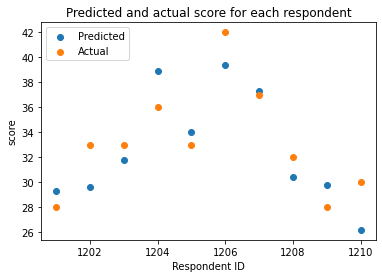

In [42]:
respondent_list = df_happiness_test.index[0:10]
yset1 = df_happiness_test['prediction'][0:10]
yset2 = df_happiness_test['14_happiness'][0:10]
plt.scatter(respondent_list,yset1,label='Predicted')
plt.scatter(respondent_list,yset2,label='Actual')
plt.xlabel('Respondent ID') 
plt.ylabel('score')
plt.legend(loc='upper left')
plt.title("Predicted and actual score for each respondent")
plt.show()

Another method of visualizing these predictions is to create a scatter plot with the X variable as the respondent ID and the Y variable as the prediction's error (measured as predicted score - actual score). This plot (shown below) demonstrates that all predicted happiness scores were within roughly 4 points of participants' actual happiness scores.

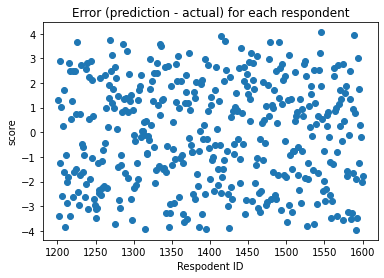

In [33]:
respondent_list = df_happiness_test.index
residual = df_happiness_test['prediction']-df_happiness_test['14_happiness']
plt.scatter(respondent_list,residual)
plt.xlabel('Respodent ID') 
plt.ylabel('score')
plt.title("Error (prediction - actual) for each respondent")
plt.show()


## Conclusion

Although this program uses fictional data, the concepts it demonstrates (correlation matrices; scatter plot visualizations; best subset regressions; and predictions using regression coefficients) can be applied in real-world scenarios. I hope you found it useful!